In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df_full = pd.read_csv('full_tfidf_df.csv')
df_full.drop(columns=['Unnamed: 0'], inplace=True)
df_full[['num_tokens','mention_count','url_count','hashtag_count']] = df_full[['num_tokens','mention_count','url_count','hashtag_count']].fillna(0)
df_full=df_full.astype('int')

In [3]:
df_full

,aa,aaaaaaaaand,aaahhhhh,aahahah,aaliyah,aap,aaron,aaronmacgruder,aaryn,ab,...,zoote,zrgrizz,zuko,zulema,zulu,zzzzzz,num_tokens,mention_count,url_count,hashtag_count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,15,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,17,2,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,13,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20616,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,11,0,0,0
20617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20618,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,20,0,0,0


In [4]:
features = df_full.drop(columns = 'class')
labels = df_full['class']

### Learning Curve (for memory reasons, ran on another notebook)

from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

CV = 10
train_sizes = np.arange(500, 18500,500).tolist()
train_sizes, train_scores, validation_scores = learning_curve(
estimator = LogisticRegression(max_iter = 100000),
X = features,
y = labels, train_sizes = train_sizes, cv = CV,
scoring = 'accuracy')

import matplotlib.pyplot as plt

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
train_error = 1- train_scores_mean 
validation_error = 1 - validation_scores_mean 

plt.style.use('seaborn')
plt.plot(train_sizes, train_error, label = 'Training error')
plt.plot(train_sizes, validation_error, label = 'Validation error')
plt.ylabel('Error', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a logistic regression model', fontsize = 18, y = 1.03)
plt.legend()

According to the learning curve, the validation error appears to increase after a training set of ~14500 (70%). Therefore, the optimal training size we'll use is 70%.

### Base Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3, random_state = 0)

clf = RandomForestClassifier(max_depth=5)
y_pred = clf.fit(X_train, y_train).predict(X_test)

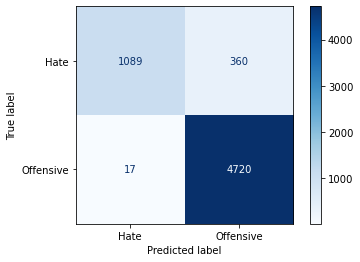

In [6]:
from sklearn.metrics import plot_confusion_matrix
class_names = ['Hate', 'Offensive']
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, display_labels = class_names, values_format = '')

In [7]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1449
           1       0.93      1.00      0.96      4737

    accuracy                           0.94      6186
   macro avg       0.96      0.87      0.91      6186
weighted avg       0.94      0.94      0.94      6186



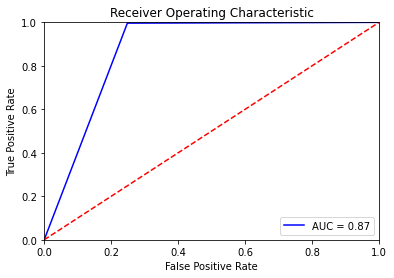

In [8]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Using imblearn to balance samples

### Random Undersampling

In [10]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline

under_pipeline = make_pipeline(RandomUnderSampler(random_state=0), clf)

under_pipeline

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=0)),
                ('randomforestclassifier', RandomForestClassifier())])

In [11]:
y_preds_under = under_pipeline.fit(X_train, y_train).predict(X_test)

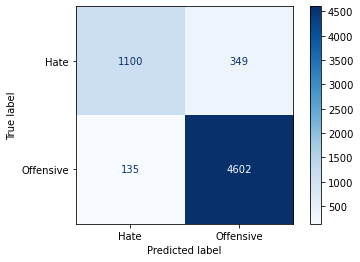

In [12]:
plot_confusion_matrix(under_pipeline, X_test, y_test, cmap=plt.cm.Blues, display_labels = class_names, values_format = '')

In [13]:
report = classification_report(y_test, y_preds_under)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1449
           1       0.93      0.97      0.95      4737

    accuracy                           0.92      6186
   macro avg       0.91      0.87      0.88      6186
weighted avg       0.92      0.92      0.92      6186



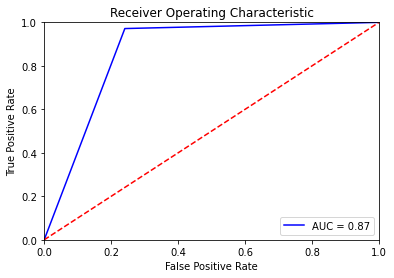

In [14]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_preds_under)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random Oversampling

In [15]:
from imblearn.over_sampling import RandomOverSampler
 

param_grid = [{}]

over_pipeline = make_pipeline(RandomOverSampler(random_state=0), clf)
over_pipeline

Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=0)),
                ('randomforestclassifier', RandomForestClassifier())])

In [16]:
y_preds_over = over_pipeline.fit(X_train, y_train).predict(X_test)

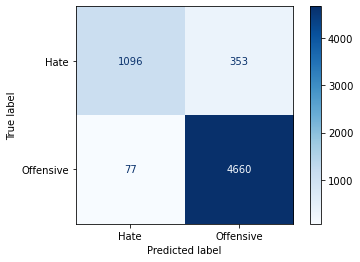

In [17]:
plot_confusion_matrix(over_pipeline, X_test, y_test, cmap=plt.cm.Blues, display_labels = class_names, values_format = '')

In [18]:
report = classification_report(y_test, y_preds_over)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.76      0.84      1449
           1       0.93      0.98      0.96      4737

    accuracy                           0.93      6186
   macro avg       0.93      0.87      0.90      6186
weighted avg       0.93      0.93      0.93      6186



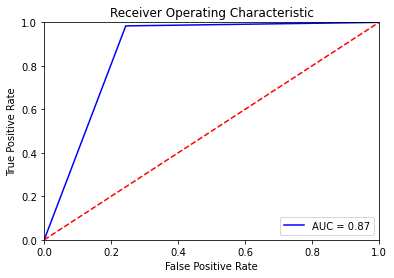

In [19]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_preds_over)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Near Miss undersampling

In [20]:
from imblearn.under_sampling import NearMiss

param_grid = [{}]
nm1 = NearMiss()
nearmiss1_pipeline = make_pipeline(nm1, clf)

nearmiss1_pipeline

Pipeline(steps=[('nearmiss', NearMiss()),
                ('randomforestclassifier', RandomForestClassifier())])

In [21]:
y_preds_nm1 = nearmiss1_pipeline.fit(X_train, y_train).predict(X_test)

              precision    recall  f1-score   support

           0       0.53      0.82      0.65      1449
           1       0.93      0.78      0.85      4737

    accuracy                           0.79      6186
   macro avg       0.73      0.80      0.75      6186
weighted avg       0.84      0.79      0.80      6186



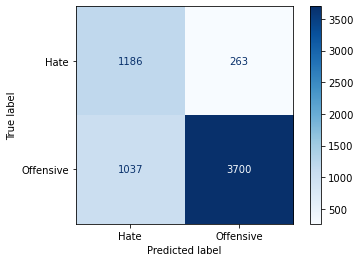

In [22]:
plot_confusion_matrix(nearmiss1_pipeline, X_test, y_test, cmap=plt.cm.Blues, display_labels = class_names, values_format = '')
report = classification_report(y_test, y_preds_nm1)
print(report)

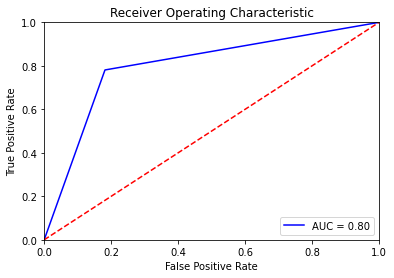

In [23]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_preds_nm1)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### SMOTE oversampling

In [24]:
from imblearn.over_sampling import SMOTE

param_grid = [{}]
smote_pipeline = make_pipeline(SMOTE(), clf)

smote_pipeline

Pipeline(steps=[('smote', SMOTE()),
                ('randomforestclassifier', RandomForestClassifier())])

              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1449
           1       0.93      0.99      0.96      4737

    accuracy                           0.93      6186
   macro avg       0.93      0.87      0.90      6186
weighted avg       0.93      0.93      0.93      6186



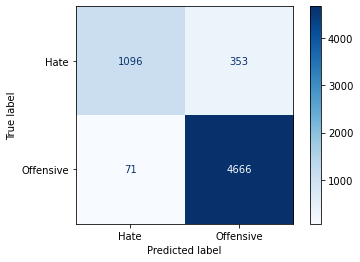

In [25]:
y_preds_smote = smote_pipeline.fit(X_train, y_train).predict(X_test)
plot_confusion_matrix(smote_pipeline, X_test, y_test, cmap=plt.cm.Blues, display_labels = class_names, values_format = '')
report = classification_report(y_test, y_preds_smote)
print(report)

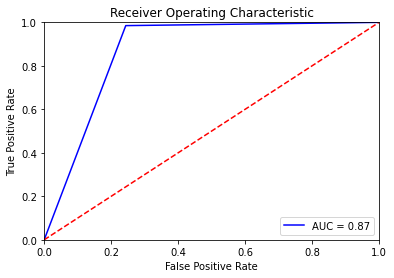

In [26]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_preds_smote)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Doesn't seem like balancing the dataset actually increases model performance.

### Grid Search - Hyperparameter Tuning for Logistic Regression

In [ ]:
grid_values = {'C':[0.001,0.009,0.01,0.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values)
y_preds_grid = grid_clf_acc.fit(X_train, y_train).predict(X_test)

In [ ]:
plot_confusion_matrix(grid_clf_acc, X_test, y_test, cmap=plt.cm.Blues, display_labels = class_names, values_format = '')
report = classification_report(y_test, y_preds_grid)
print(report)

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_preds_grid)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()